In [1]:
!pip3 install flirt
# !pip3 install imblearn
import flirt
import os, sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from xgboost import XGBClassifier
from collections import Counter
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc, f1_score, precision_score, recall_score
# from imblearn.over_sampling import SMOTE
# initialize the root path to the project
ROOT_DIR = os.path.abspath("../")

# Assignment 3: Stress Detection
### Name: Ha Le
### Date: 11/02/2022

This notebook contains my work for assignment 3, Stress Detection. The dataset used in this notebook is from Bosch, called the WESAD dataset (Schimidt et al.). the goal of this assignment is to classifying moment of stress in a controlled lab settings.

## Step 1: Download the Dataset.

I have downloaded the dataset from [this](https://ubicomp.eti.uni-siegen.de/home/datasets/icmi18/) link. The dataset is currently in the [data](../data/raw/) folder of this project.

## Step 2: Data Cleaning, Segmentation, and Features Extraction.

The second step of the project is to clean, segment and extracting features from the dataset. Instead of creating my own pipeline like in assignment 2, I will be using the python package [FLIRT](https://flirt.readthedocs.io/en/latest/index.html) to help accelerate the process.

There are 15 participants in this study, labelling from S2 to S17 (except for S12). We will read and perform features extraction on each of the user's dataset, and store them in separate dataframes:

In [2]:
#initialize the dictionary that srote the dataframes of different participants
features_dict = {}

# read the emphatica data from each participant and use flirt to preprocess the data
for id in range(2, 18):
    if id == 12:
        continue
    # ignore the warning of flirt since it can be lengthy to look at
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        features = flirt.simple.get_features_for_empatica_archive(ROOT_DIR + f"/data/raw/WESAD/S{id}/S{id}_E4_Data.zip", 60, 10, True, True, False)
        # convert the index to datetime
        features.index = pd.to_datetime(features.index)
        features_dict[id] = features

# orint out one dataframe of one participant to see the data
features_dict[2].head()

EDA features: 100%|██████████| 724/724 [00:00<00:00, 925.58it/s]


,num_ibis,hrv_mean_nni,hrv_median_nni,hrv_range_nni,hrv_sdsd,hrv_rmssd,hrv_nni_50,hrv_pnni_50,hrv_nni_20,hrv_pnni_20,...,eda_phasic_n_above_mean,eda_phasic_n_below_mean,eda_phasic_n_sign_changes,eda_phasic_iqr,eda_phasic_iqr_5_95,eda_phasic_pct_5,eda_phasic_pct_95,eda_phasic_entropy,eda_phasic_perm_entropy,eda_phasic_svd_entropy
2017-05-22 07:16:25+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,88.0,152.0,1.0,0.850479,2.088944,0.009984,2.098928,4.886732,0.999371,0.322548
2017-05-22 07:16:35+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,102.0,138.0,2.0,1.161415,2.103016,-0.000704,2.102312,-inf,0.966334,0.315608
2017-05-22 07:16:45+00:00,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,116.0,124.0,1.0,0.850437,2.054713,0.020745,2.075458,5.233475,0.991959,0.308793
2017-05-22 07:16:55+00:00,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,103.0,137.0,1.0,0.560326,1.760357,0.331890,2.092247,5.350969,0.999371,0.325930
2017-05-22 07:17:05+00:00,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,140.0,100.0,2.0,0.615449,1.123332,0.101401,1.224733,-inf,0.993196,0.323172


It seems like the package works seemlessly with our dataset!

## Step 3: Syncing labels with wearable data
Since the dataframes above did not contain any labels, we can't just jump right into classfication yet. We need to extract the labels from the _quest.csv file, and merge the labels into our dataset.

First, let's take a look at one of the labels file to see its content:



In [3]:
# grasping one of the _quest.csv file and display the data, with ; as the seperator
quest = pd.read_csv(ROOT_DIR + "/data/raw/WESAD/S2/S2_quest.csv", sep=';')
quest.head()

,# Subj,S2,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,# ORDER,Base,TSST,Medi 1,Fun,Medi 2,sRead,fRead,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,# START,7.08,39.55,70.19,81.25,93.38,54.42,89.51,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,# END,26.32,50.3,77.1,87.47,100.15,56.07,91.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,# PANAS,1,1,3,2,1,3,1,1.0,1.0,...,4.0,4.0,2.0,2.0,2.0,1.0,2.0,1.0,NaN,NaN


The labeling file is a bit messy, but we only want to extract the start and end time of the baseline and the stress task (TSST). The next chunk of code will pull the start and end time for "Base" and "TSST" for each user and put them into a dictionary.

In [21]:
#initialize the dictionary that store the start/end time of the baseline and stress period
stress_interval_dict = {}

# grasp the start and end time from the quest dataframe
for user in range(2, 18):
    if user == 12:
        continue
    quest = pd.read_csv(ROOT_DIR + f"/data/raw/WESAD/S{user}/S{user}_quest.csv", sep=';')
    # we only care about the first 3 columns
    quest = quest.iloc[:, :3]
    # we only care about the first 3 rows
    quest = quest.iloc[:3, :]
    # rename the columns into ["subj", "start", "end"]
    quest.columns = ["subj", "start", "end"]
    # grasp the start_time of the baseline activity, convert it into dateimte delta
    # get the minutes and seconds of the start_time of the baseline activity
    if '.' in quest.iloc[1, 1]:
        start_time_minute, start_time_second = quest.iloc[1, 1].split(".")
        start_time = timedelta(minutes=float(start_time_minute), seconds=float(start_time_second))
    else:
        start_time = timedelta(minutes=float(quest.iloc[1, 1]))
    # grasp the end_time of the baseline activity, convert it into dateimte delta
    # get the minutes and seconds of the end_time of the stress activity
    if '.' in quest.iloc[2, 1]:
        end_time_minute, end_time_second = quest.iloc[2, 1].split(".")
        end_time = timedelta(minutes=float(end_time_minute), seconds=float(end_time_second))
    else:
        end_time = timedelta(minutes=float(quest.iloc[2, 1]), seconds=0)
    #grasp the start_time of the stress activity, convert it into dateimte delta
    # get the minutes and seconds of the start_time of the stress activity
    if '.' in quest.iloc[1, 2]:
        stress_start_time_minute, stress_start_time_second = quest.iloc[1, 2].split(".")
        stress_start_time = timedelta(minutes=float(stress_start_time_minute), seconds=float(stress_start_time_second))
    else:
        stress_start_time = timedelta(minutes=float(quest.iloc[1, 2]))
    #grasp the end_time of the stress activity, convert it into dateimte delta
    # get the minutes and seconds of the end_time of the stress activity
    if '.' in quest.iloc[2, 2]:
        stress_end_time_minute, stress_end_time_second = quest.iloc[2, 2].split(".")
        stress_end_time = timedelta(minutes=float(stress_end_time_minute), seconds=float(stress_end_time_second))
    else:
        stress_end_time = timedelta(minutes=float(quest.iloc[2, 2]))
    # put the start_time and end_time into the dictionary
    stress_interval_dict[user] = {"baseline": {"start": start_time, "end": end_time}, "stress": {"start": stress_start_time, "end": stress_end_time}}

# print out the results of user 2
stress_interval_dict[2]

{'baseline': {'start': datetime.timedelta(seconds=428),
  'end': datetime.timedelta(seconds=1592)},
 'stress': {'start': datetime.timedelta(seconds=2395),
  'end': datetime.timedelta(seconds=3003)}}

Now, we want to grasp the start time of the experiment for each user, which can be inferred as the index of the first row for the emphatica dataframe.

In [23]:
# initialize the dictionary that store the start time of the experiment for each participant
start_time_dict = {}

for user in range(2, 18):
    if user == 12:
        continue
    # the start time of the experiment is the index of the first row of the features dataframe
    start_time = features_dict[user].index[0]
    # put the start time into the dictionary
    start_time_dict[user] = start_time

# print out the start time of user 2
start_time_dict[2]

Timestamp('2017-05-22 07:16:25+0000', tz='UTC', freq='10S')

For each user, we want to get only the baseline and the stress period, label them, and put all the stress/baseline timestamp into one common dataframe (with data from all the user). We can get rid of the rest of the data.

In [24]:
# initialize the final dataframe that store the features of all participants and the label
final_df = pd.DataFrame()

# loop through all the participants
for user in range(2, 18):
    if user == 12:
        continue

    # get the start time of the experiment
    start_time = start_time_dict[user]
    # get the start time of the baseline activity
    baseline_start = stress_interval_dict[user]["baseline"]["start"]
    # get the end time of the baseline activity
    baseline_end = stress_interval_dict[user]["baseline"]["end"]
    # get the start time of the stress activity
    stress_start = stress_interval_dict[user]["stress"]["start"]
    # get the end time of the stress activity
    stress_end = stress_interval_dict[user]["stress"]["end"]
    # get the features dataframe of the user
    features = features_dict[user]
    # get the baseline features dataframe
    baseline_features = features.loc[start_time + baseline_start: start_time + baseline_end]
    # get the stress features dataframe
    stress_features = features.loc[start_time + stress_start: start_time + stress_end]
    # print("baseline_start: ", start_time + baseline_start, baseline_start)
    # print("baseline_end: ", start_time + baseline_end, baseline_end)
    # print("stress_start: ", start_time + stress_start, stress_start)
    # print("stress_end: ", start_time + stress_end, stress_end)
     # ignore the warning of concat since it can be lengthy to look at
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        # add a column to the baseline features dataframe, the value is 0
        baseline_features["label"] = 0
        # add a column to the stress features dataframe, the value is 1
        stress_features["label"] = 1
        # add the user id to the baseline features dataframe, move the column to the first column
        baseline_features.insert(0, "user", user)
        # add the user id to the stress features dataframe, move the column to the first column
        stress_features.insert(0, "user", user)
        # concatenate the baseline features dataframe and the stress features dataframe
        user_df = pd.concat([baseline_features, stress_features])
        # concatenate the user dataframe to the final dataframe
        final_df = pd.concat([final_df, user_df])

# print out the final dataframe
final_df.head()

,user,num_ibis,hrv_mean_nni,hrv_median_nni,hrv_range_nni,hrv_sdsd,hrv_rmssd,hrv_nni_50,hrv_pnni_50,hrv_nni_20,...,eda_phasic_n_below_mean,eda_phasic_n_sign_changes,eda_phasic_iqr,eda_phasic_iqr_5_95,eda_phasic_pct_5,eda_phasic_pct_95,eda_phasic_entropy,eda_phasic_perm_entropy,eda_phasic_svd_entropy,label
2017-05-22 07:23:35+00:00,2,61.8,767.133553,775.0356,234.3860,47.967353,47.996281,15.4,24.735490,36.6,...,140.0,2.0,0.020587,0.040621,-0.004735,0.035887,-inf,0.957863,0.589850,0
2017-05-22 07:23:45+00:00,2,57.2,773.805869,781.2860,234.3860,42.033322,42.051298,10.0,17.384988,33.2,...,139.0,1.0,0.020038,0.036476,0.000085,0.036560,4.933534,0.885883,0.587246,0
2017-05-22 07:23:55+00:00,2,53.0,778.318170,781.2860,234.3860,41.279268,41.281592,9.2,17.478992,30.8,...,143.0,2.0,0.019996,0.041045,-0.001636,0.039409,-inf,0.875543,0.591086,0
2017-05-22 07:24:05+00:00,2,52.8,792.254337,790.6610,215.6348,39.361808,39.396494,8.8,16.732026,30.0,...,169.0,3.0,0.005211,0.034263,-0.004960,0.029303,-inf,0.726963,0.736138,0
2017-05-22 07:24:15+00:00,2,57.0,800.842850,796.9110,221.8846,40.378157,40.442510,9.8,17.112367,35.4,...,181.0,3.0,0.007953,0.047757,-0.000006,0.047751,-inf,0.709955,0.680942,0


To confirm that the filtering and labelling works according to the way we want, I want to make a graph of the baseline and stress period.

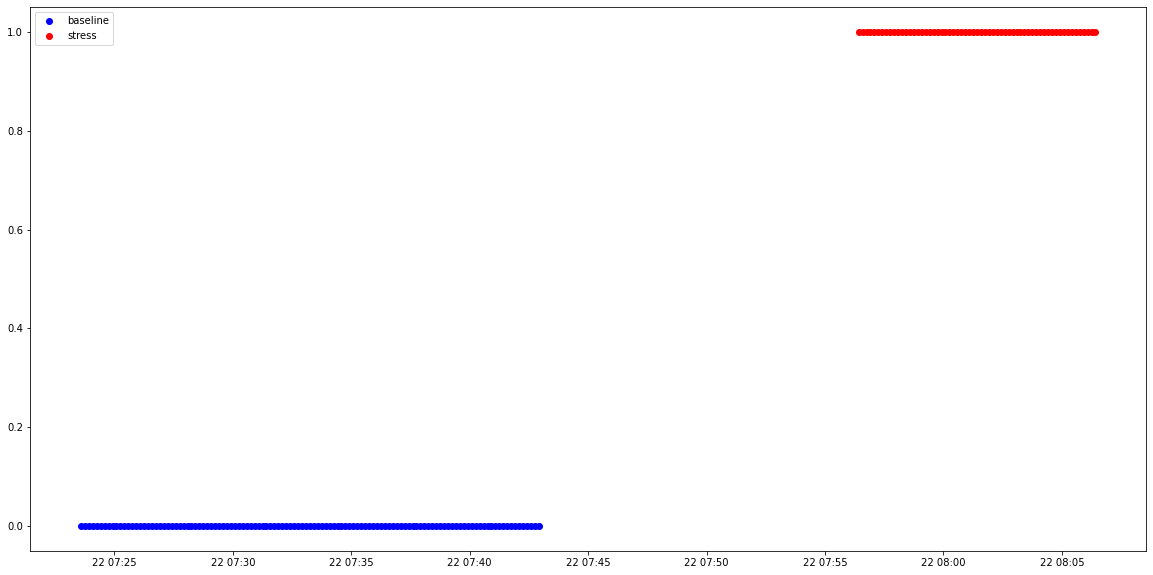

In [25]:
def plot_baseline_stress_timestamp(subject_id):
    # filter out the data of the subject
    subject_df = final_df[final_df["user"] == subject_id]
    # get the rows with label 0 (baseline)
    baseline_df = subject_df[subject_df["label"] == 0]
    # get the rows with label 1 (stress)
    stress_df = subject_df[subject_df["label"] == 1]
    #get the timestampt of the baseline
    baseline_timestamp = baseline_df.index
    #get the timestampt of the stress
    stress_timestamp = stress_df.index
    # plot the baseline and stress timestamp
    plt.figure(figsize=(10, 5))
    plt.plot(baseline_timestamp, np.zeros(len(baseline_timestamp)), 'o', color='blue', label='baseline')
    plt.plot(stress_timestamp, np.ones(len(stress_timestamp)), 'o', color='red', label='stress')
    plt.legend()
    plt.show()

# plot the baseline and stress timestamp of user 2
plot_baseline_stress_timestamp(2)

For the sake of my convenience, I'll save the final clean dataframe into a csv file, inside the [/data/filtered](../data/filtered/) folder.

In [7]:
# save the final dataframe to a csv file inside the data/filtered folder
final_df.to_csv(ROOT_DIR + "/data/filtered/filtered_features.csv")

## Step 4: Train classifier and evaluate the performance

The last step of this project is to train the classifier on the clean data we just created and evaluate the performances of machine learning models. For this project, I will be using SVM for classification, since the features are continuous.

In this notebook, we will be using the leave-one-subject-out cross validation method.

In [26]:
# reading the data files from the data/filtered folder
filtered_features = pd.read_csv(ROOT_DIR + "/data/filtered/filtered_features.csv", index_col=False)
filtered_features.head()

,Unnamed: 0,user,num_ibis,hrv_mean_nni,hrv_median_nni,hrv_range_nni,hrv_sdsd,hrv_rmssd,hrv_nni_50,hrv_pnni_50,...,eda_phasic_n_below_mean,eda_phasic_n_sign_changes,eda_phasic_iqr,eda_phasic_iqr_5_95,eda_phasic_pct_5,eda_phasic_pct_95,eda_phasic_entropy,eda_phasic_perm_entropy,eda_phasic_svd_entropy,label
0,2017-05-22 07:23:35+00:00,2,61.8,767.133553,775.0356,234.3860,47.967353,47.996281,15.4,24.735490,...,140.0,2.0,0.020587,0.040621,-0.004735,0.035887,-inf,0.957863,0.589850,0
1,2017-05-22 07:23:45+00:00,2,57.2,773.805869,781.2860,234.3860,42.033322,42.051298,10.0,17.384988,...,139.0,1.0,0.020038,0.036476,0.000085,0.036560,4.933534,0.885883,0.587246,0
2,2017-05-22 07:23:55+00:00,2,53.0,778.318170,781.2860,234.3860,41.279268,41.281592,9.2,17.478992,...,143.0,2.0,0.019996,0.041045,-0.001636,0.039409,-inf,0.875543,0.591086,0
3,2017-05-22 07:24:05+00:00,2,52.8,792.254337,790.6610,215.6348,39.361808,39.396494,8.8,16.732026,...,169.0,3.0,0.005211,0.034263,-0.004960,0.029303,-inf,0.726963,0.736138,0
4,2017-05-22 07:24:15+00:00,2,57.0,800.842850,796.9110,221.8846,40.378157,40.442510,9.8,17.112367,...,181.0,3.0,0.007953,0.047757,-0.000006,0.047751,-inf,0.709955,0.680942,0


Since SVC does not accept the NaN values, we want to examine how many datapoints in our dataset contains NaN values.

In [27]:
# check the number of rows with NaN values
print("Number of rows with Nan values: ", filtered_features.isna().any(axis=1).sum())
print("Total number of rows: ", filtered_features.shape[0])


Number of rows with Nan values:  11
Total number of rows:  4070


There isn't many rows with NaN values, so I will just drop them instead of trying to impute.

In [28]:
# drop the rows with NaN values
filtered_features = filtered_features.dropna()
# check the number of rows with NaN values after dropping
print("Number of rows with Nan values (after dropping): ", filtered_features.isna().any(axis=1).sum())

Number of rows with Nan values (after dropping):  0


We also want to replace any values inf or -inf with a very large/small float64 number.

In [29]:
# replace the inf values with very large numbers
filtered_features = filtered_features.replace([np.inf], 1e9)
# replace the -inf values with very small numbers
filtered_features = filtered_features.replace([-np.inf], -1e9)

I want to check the number of data points in each class just to make sure we have a balanced dataset.

In [30]:
# check the number of samples for each label
filtered_features["label"].value_counts()


0    2526
1    1533
Name: label, dtype: int64

The code below initialize the cross validation methods and the necessary lists to store the metrics. I will record the accuracy, f1 score, precision, recal and AUROC scores for each fold and report the average.

In [31]:
# initialize the LOGO cross validation
logo = LeaveOneGroupOut()
# initialize the list that store the accuracy of each fold
accuracy_list = []
# initialize the list that store the confusion matrix of each fold
confusion_matrix_list = []
# initialize the list that store the f1 score of each fold
f1_list = []
# initialize the list that store the precision of each fold
precision_list = []
# initialize the list that store the recall of each fold
recall_list = []
# initialize the list that store the roc_auc of each fold
roc_auc_list = []


In [14]:
# write a function to apply SMOTE to the training data
def apply_smote(X_train, y_train):
    '''
    Apply SMOTE to the training data
    :param X_train: the training features
    :param y_train: the training labels
    :return: the oversampled training features and labels
    '''
    # apply SMOTE
    sm = SMOTE(random_state=42, sampling_strategy='minority', n_jobs=-1)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    # return the new training data
    return X_train, y_train

Now for the training and evaluation part ...

In [32]:
# creating the fold for the cross validation according to the user id
groups = filtered_features["user"].values

# get the X and y, dropping the user id column and the label column and index column
X = filtered_features.drop(["user", "label", "Unnamed: 0"], axis=1)
y = filtered_features["label"]

# loop through the fold
for train_index, test_index in logo.split(X, y, groups):
    # get the X_train, X_test, y_train, y_test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # try scaling the data
    # X_train = StandardScaler().fit_transform(X_train)
    # X_test = StandardScaler().fit_transform(X_test)
    # apply SMOTE to the training data
    # X_train, y_train = apply_smote(X_train, y_train)
    # initialize the random forest classifier
    clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
    # fit the classifier to the training data
    clf.fit(X_train, y_train)
    # get the prediction of the test data
    y_pred = clf.predict(X_test)
    # count the labels of the prediction and the training data
    print("Training data label count: ", Counter(y_train))
    print("Prediction label count: ", Counter(y_pred))
    # get the accuracy of the prediction
    accuracy = accuracy_score(y_test, y_pred)
    # get the confusion matrix of the prediction
    # confusion_matrix = confusion_matrix(y_test, y_pred)
    # get the f1 score of the prediction
    f1 = f1_score(y_test, y_pred)
    # get the precision of the prediction
    precision = precision_score(y_test, y_pred)
    # get the recall of the prediction
    recall = recall_score(y_test, y_pred)
    # get the roc_auc of the prediction
    roc_auc = roc_auc_score(y_test, y_pred)
    # append the accuracy to the accuracy list
    accuracy_list.append(accuracy)
    # append the confusion matrix to the confusion matrix list
    # confusion_matrix_list.append(confusion_matrix)
    # append the f1 score to the f1 list
    f1_list.append(f1)
    # append the precision to the precision list
    precision_list.append(precision)
    # append the recall to the recall list
    recall_list.append(recall)
    # append the roc_auc to the roc_auc list
    roc_auc_list.append(roc_auc)


# print out the average accuracy, average f1 score, average precision, average recall, average roc_auc
print("Average accuracy: ", np.mean(accuracy_list))
print("Average f1 score: ", np.mean(f1_list))
print("Average precision: ", np.mean(precision_list))
print("Average recall: ", np.mean(recall_list))
print("Average roc_auc: ", np.mean(roc_auc_list))

# print out the confusion matrix of the first fold
# confusion_matrix_list[1]

Training data label count:  Counter({0: 2329, 1: 1392})
Prediction label count:  Counter({0: 332, 1: 6})
Training data label count:  Counter({0: 2337, 1: 1394})
Prediction label count:  Counter({0: 257, 1: 71})
Training data label count:  Counter({0: 2372, 1: 1454})
Prediction label count:  Counter({1: 143, 0: 90})
Training data label count:  Counter({0: 2367, 1: 1457})
Prediction label count:  Counter({0: 143, 1: 92})
Training data label count:  Counter({0: 2346, 1: 1406})
Prediction label count:  Counter({0: 301, 1: 6})
Training data label count:  Counter({0: 2381, 1: 1468})
Prediction label count:  Counter({0: 198, 1: 12})
Training data label count:  Counter({0: 2375, 1: 1465})
Prediction label count:  Counter({0: 130, 1: 89})
Training data label count:  Counter({0: 2351, 1: 1411})
Prediction label count:  Counter({0: 235, 1: 62})
Training data label count:  Counter({0: 2371, 1: 1459})
Prediction label count:  Counter({0: 186, 1: 43})
Training data label count:  Counter({0: 2344, 1:

/Users/hale/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training data label count:  Counter({0: 2338, 1: 1395})
Prediction label count:  Counter({0: 174, 1: 152})
Training data label count:  Counter({0: 2376, 1: 1462})
Prediction label count:  Counter({0: 178, 1: 43})
Training data label count:  Counter({0: 2339, 1: 1394})
Prediction label count:  Counter({1: 246, 0: 80})
